In [1]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
nlp = spacy.load('en_core_web_sm')

with open('brennu-njals_saga_en.txt', 'r', encoding='utf-8') as file:
    book_text = file.read()

doc = nlp(book_text)

In [3]:
characters = []

for entity in doc.ents:
    if entity.label_ == 'PERSON':  # Consider only the entities labeled as persons
        characters.append(entity.text)

In [4]:
G = nx.Graph()

for character in characters:
    G.add_node(character)

In [5]:
for sentence in doc.sents:
    sentence_characters = []

    for entity in sentence.ents:
        if entity.label_ == 'PERSON':
            sentence_characters.append(entity.text)

    for i, character1 in enumerate(sentence_characters):
        for character2 in sentence_characters[i + 1:]:
            if G.has_edge(character1, character2):
                G[character1][character2]['weight'] += 1
            else:
                G.add_edge(character1, character2, weight=1)

# Get a list of nodes without edges
isolated_nodes = [node for node, degree in dict(G.degree()).items() if degree == 0]
G.remove_nodes_from(isolated_nodes)

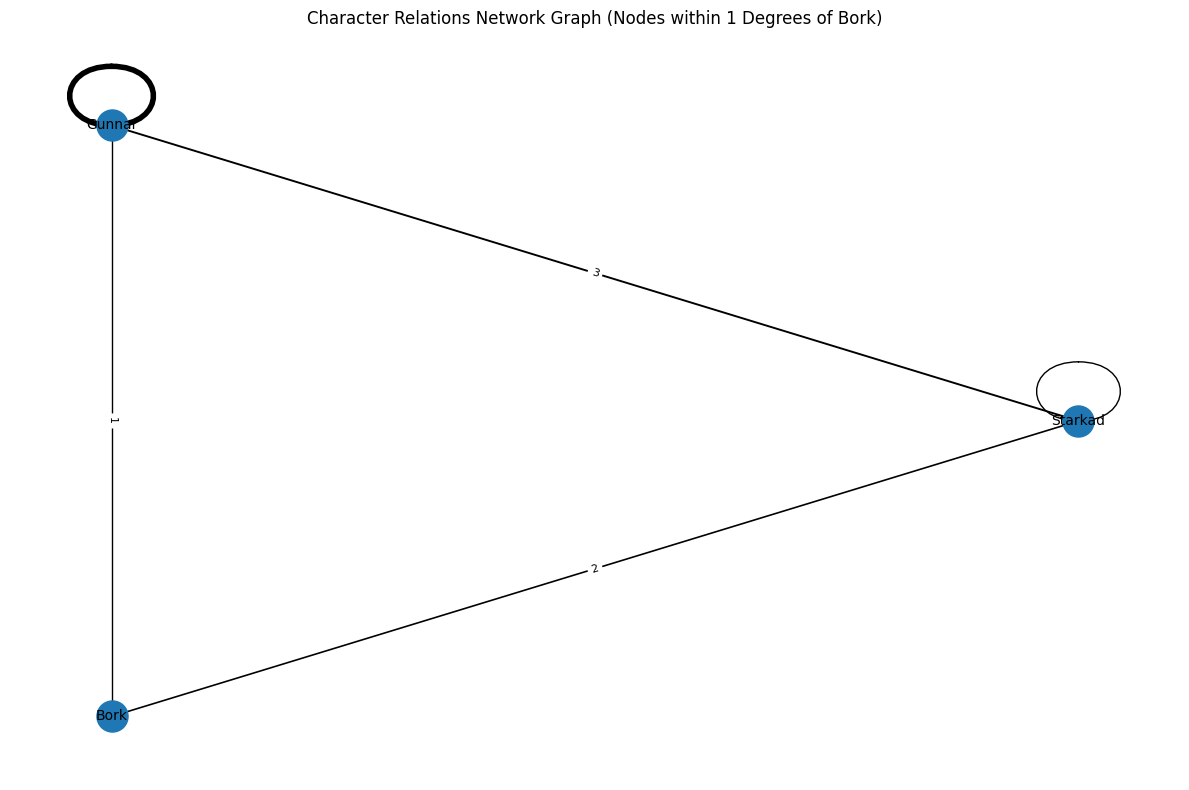

In [6]:
chosen_node = input("Enter a character: ")  # Specify the chosen node

subgraph_nodes = set(nx.single_source_shortest_path_length(G, chosen_node, cutoff=1))
subgraph = G.subgraph(subgraph_nodes)

# Get edge weights
edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]

# Normalize the edge weights to be within a specific range
min_weight = min(edge_weights)
max_weight = max(edge_weights)
edge_weights_normalized = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]

# Define the widths of the edges based on the normalized weights
edge_widths = [1 + 3 * weight for weight in edge_weights_normalized]

pos = nx.circular_layout(subgraph)  # Adjust layout algorithm as needed

plt.figure(figsize=(12, 8))
nx.draw_networkx(subgraph, pos, with_labels=True, node_size=500, font_size=10, width=edge_widths)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
plt.title(f'Character Relations Network Graph (Nodes within 1 Degrees of {chosen_node})')
plt.axis('off')
plt.tight_layout()
plt.show()

# Plotly

In [23]:
chosen_node = input("Enter a character: ")  # Specify the chosen node

subgraph_nodes = set(nx.single_source_shortest_path_length(G, chosen_node, cutoff=1))
subgraph = G.subgraph(subgraph_nodes)

# Calculate the positions of nodes in the subgraph using a layout algorithm
pos = nx.circular_layout(subgraph)

# Create a list of edges and their weights
edges = []
edge_weights = []
for u, v, data in subgraph.edges(data=True):
    edges.append((u, v))
    edge_weights.append(data['weight'])

# Normalize the edge weights to be within a specific range
min_weight = min(edge_weights)
max_weight = max(edge_weights)
edge_weights_normalized = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]

# Define the minimum and maximum width for the edges
min_edge_width = 1.0
max_edge_width = 5.0

# Create a list of nodes
nodes = list(subgraph.nodes())

# Create a list of node positions
node_positions = [pos[node] for node in nodes]

# Create the trace for edges
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create the trace for nodes
node_trace = go.Scatter(
    x=[],
    y=[],
    text=nodes,
    mode='markers+text',
    hoverinfo='text',
    textposition='top center',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        line=dict(width=0.5)
    )
)

# Add edge positions and widths to the edge trace
for edge, weight_normalized in zip(edges, edge_weights_normalized):
    x0, y0 = node_positions[nodes.index(edge[0])]
    x1, y1 = node_positions[nodes.index(edge[1])]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['line']['width'] = min_edge_width + (max_edge_width - min_edge_width) * weight_normalized

# Add node positions and colors to the node trace
for node, pos in zip(nodes, node_positions):
    x, y = pos
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple([len(subgraph[node])])

# Get the position of the chosen node
chosen_node_index = nodes.index(chosen_node)
chosen_node_position = node_positions[chosen_node_index]

# Add the chosen node to the node trace
node_trace['x'] += tuple([chosen_node_position[0]])
node_trace['y'] += tuple([chosen_node_position[1]])
node_trace['marker']['color'] += tuple([len(subgraph[chosen_node])])

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=f'Character Relations Network Graph (Nodes within 1 Degree of {chosen_node})',
                    titlefont=dict(size=16),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Save the graph as an HTML file
pio.write_html(fig, 'graph.html', auto_open=True)